In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LANGUAGE CLASSIFICATION USING N-GRAM ENCODING WITH DIFFERENT MACHINE LEARNING CLASSIFIERS

This notebook presents a complete pipeline for text classification using n-gram encoding with hyperdimensional vectors and Ridge regression.

Install necessary libraries

In [ ]:
!pip install langid
!pip install langdetect
!pip install deep-translator
!pip install contractions
!pip install nltk
!pip install wordcloud
!pip install seaborn
!pip install tqdm

# Download NLTK data
!python -m nltk.downloader punkt
!python -m nltk.downloader stopwords
!python -m nltk.downloader wordnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=8b5da917623e1481d0db0ac13a388985ba676b6b5755082fb9127c55f537ad4c
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=dfef24d6b365a99efb4c8c9c984e6199f635abca06ba43d22e84a2c94e6018bb
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

Import Necessary Libraries:

In [ ]:
import os
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from tqdm import tqdm
from collections import defaultdict, Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import langid
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

from langdetect import detect
from deep_translator import GoogleTranslator
import contractions

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Data

In this step, first specify the base path  of the data files. Additionally, due to limited computational resources and time constraints, extract 200 sentences from each language folder for processing.


In [ ]:
BASE_PATH = "/content/drive/MyDrive/dataset/dataset"
NUM_SENTENCES = 200
LANGUAGES = [
    "bel_wikipedia_2021_10K",
    "che_wikipedia_2021_10K",
    "dan_wikipedia_2021_10K",
    "deu_wikipedia_2021_10K",
    "ell_wikipedia_2021_10K",
    "eng-simple_wikipedia_2021_10K",
    "est_wikipedia_2014_10K",
    "fin_wikipedia_2021_10K",
    "fra_wikipedia_2021_10K",
    "hun_wikipedia_2021_10K",
    "ita_wikipedia_2021_10K",
    "lav_wikipedia_2014_10K",
    "lit_wikipedia_2021_10K",
    "nld_wikipedia_2021_10K",
    "pol_wikipedia_2021_10K",
    "por_wikipedia_2021_10K",
    "ron_wikipedia_2021_10K",
    "slk_wikipedia_2021_10K",
    "slv_wikipedia_2021_10K",
    "spa_wikipedia_2021_10K",
    "swe_wikipedia_2021_10K"
]

if not os.path.exists(BASE_PATH):
    logging.error(f"Base path {BASE_PATH} does not exist.")
    raise FileNotFoundError(f"Base path {BASE_PATH} does not exist.")

for lang in LANGUAGES:
    example_file = os.path.join(BASE_PATH, lang, f"{lang}-sentences.txt")
    if not os.path.isfile(example_file):
        logging.warning(f"File {example_file} does not exist.")
    else:
        print(f"Found file: {example_file}")

Found file: /content/drive/MyDrive/dataset/dataset/bel_wikipedia_2021_10K/bel_wikipedia_2021_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/che_wikipedia_2021_10K/che_wikipedia_2021_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/dan_wikipedia_2021_10K/dan_wikipedia_2021_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/deu_wikipedia_2021_10K/deu_wikipedia_2021_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/ell_wikipedia_2021_10K/ell_wikipedia_2021_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/eng-simple_wikipedia_2021_10K/eng-simple_wikipedia_2021_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/est_wikipedia_2014_10K/est_wikipedia_2014_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/fin_wikipedia_2021_10K/fin_wikipedia_2021_10K-sentences.txt
Found file: /content/drive/MyDrive/dataset/dataset/fra_wikipedia_2021_10K/fra_wikipedia_2021_10K-s

# Data Chunking and Preparation

This part of the code reads sentences from files in various language folders, extracts a specified number of sentences, and saves them to new files.


1. Read and process text files containing sentences for various languages.  
2. Extract a fixed number of sentences (200) from each language folder.
3. Save these sentences to a new file for further use.
4. Handle errors, logging issues encountered during file operations and directory listing.


In [ ]:
def process_sentences(file_path):
    """
    Read sentences from the specified file.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            sentences = file.readlines()
        return sentences
    except Exception as e:
        logging.error(f"Failed to read file {file_path}: {e}")
        return []

def extract_and_save_sentences(folder_name):
    """
    Extract 200 sentences from a language folder and save them to a new file.
    """
    sentences_file = os.path.join(BASE_PATH, folder_name, f"{folder_name}-sentences.txt")

    if not os.path.exists(sentences_file):
        logging.warning(f"Sentences file not found for folder {folder_name}.")
        return

    sentences = process_sentences(sentences_file)

    if not sentences:
        logging.warning(f"No sentences extracted for folder {folder_name}.")
        return

    extracted_sentences = sentences[:NUM_SENTENCES]

    output_file = os.path.join(BASE_PATH, folder_name, 'extracted_sentences.txt')
    try:
        with open(output_file, 'w', encoding='utf-8') as file:
            file.writelines(extracted_sentences)
        logging.info(f"Extracted 2000 sentences for folder {folder_name} saved to '{output_file}'.")
    except Exception as e:
        logging.error(f"Failed to write file {output_file}: {e}")

def list_folders(base_path):
    """
    List all folders in the specified directory.
    """
    try:
        return [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    except Exception as e:
        logging.error(f"Failed to list folders in directory {base_path}: {e}")
        return []

def process_all_folders():
    """
    Process all language folders and extract sentences.
    """
    try:
        # List all folders in the base directory
        language_folders = list_folders(BASE_PATH)

        if not language_folders:
            logging.warning("No language folders found in the base directory.")
            return

        for folder in language_folders:
            logging.info(f"Processing folder: {folder}")
            extract_and_save_sentences(folder)

    except Exception as e:
        logging.error(f"An error occurred: {e}")

process_all_folders()

Display the contents of specific text files from various language folders to help verify or review the extracted sentences.

In [ ]:
def print_extracted_sentences(folder_name):
    """
    Print the contents of the 'extracted_sentences.txt' file from the specified folder.
    """
    extracted_file = os.path.join(BASE_PATH, folder_name, 'extracted_sentences.txt')

    if not os.path.exists(extracted_file):
        print(f"File not found: {extracted_file}")
        return

    try:
        with open(extracted_file, 'r', encoding='utf-8') as file:
            contents = file.readlines()
        print(f"Contents of '{folder_name}/extracted_sentences.txt':")
        for line in contents:
            print(line.strip())
    except Exception as e:
        print(f"Failed to read file {extracted_file}: {e}")

language_folders = list_folders(BASE_PATH)
for folder in language_folders:
    print_extracted_sentences(folder)

Contents of 'slv_wikipedia_2021_10K/extracted_sentences.txt':
1	; 1944 se je vrnil domov v Novo Zelandijo.
2	« (1986) kot podlaga za »
3	; 1. maja istega leta je bil ustoličen in kronan.
4	; 20. novembra istega leta je podobna usoda doletela tudi III.
5	" (23) otvori Mit o Sizifu, je, ali naj se človek ubije ali ne.
6	; 4. Vedno zmaga pravica nad krivico, resnica nad lažjo …
7	Aachenska stolnica je bila v času Karla Velikega ometana rdeče, kar so najnovejše ugotovitve Renskega urada za spomenike.
8	Abdul Hamid je misorskim poslancem odgovoril, da je cesarstvo že vpleteno v izčrpavajočo vojno z Rusijo in Avstrijo in zato ne more pomagati.
9	Aborigini so večinoma uživali raznoliko hrano živalskega in rastlinskega izvora, ki se je spreminjala glede na letni čas in lokalne razmere.
10	Absolutizem je oblika vladanja, ki dá vladarju popolno in neomejeno oblast, vladar odloča o vseh stvareh sam.
11	Absorbirajte ali prekrijte s suho zemljo, peskom ali drugim negorljivim materialom ter prenesit

# Advanced Data Cleaning and Preprocessing

This code performs text preprocessing and analysis on extracted sentences from multiple language folders. It involves the following steps:

1.   **Initialization**  (Lemmatizer, Language Mapping, Stopwords)
2.  **Text Cleaning Functions** (Expand Contractions,Remove Special Characters,
Remove URLs, Remove HTML Tags, Remove Accents, Lemmatize Text, Remove Page Numbers)
3.   **Text Processing Functions**  (Generate Trigrams, Clean Text)
4.   **Data Loading and Cleaning** (Detect Language, Filter Short Samples,
Remove Empty Samples, Load and Clean Data)
5.   **Data Display and Analysis** (Display Preprocessed Data, Check Trigram Matches)











In [ ]:
lemmatizer = WordNetLemmatizer()

LANGUAGE_MAP = {
    'be': 'bel_wikipedia_2021_10K', 'ch': 'che_wikipedia_2021_10K', 'da': 'dan_wikipedia_2021_10K', 'de': 'deu_wikipedia_2021_10K',
    'el': 'ell_wikipedia_2021_10K','en': 'eng-simple_wikipedia_2021_10K', 'et': 'est_wikipedia_2014_10K', 'fi': 'fin_wikipedia_2021_10K',
    'fr': 'fra_wikipedia_2021_10K','hu': 'hun_wikipedia_2021_10K', 'it': 'ita_wikipedia_2021_10K','lv': 'lav_wikipedia_2014_10K',
    'lt': 'lit_wikipedia_2021_10K', 'nl': 'nld_wikipedia_2021_10K','pl': 'pol_wikipedia_2021_10K','pt': 'por_wikipedia_2021_10K',
    'ro': 'ron_wikipedia_2021_10K','sk': 'slk_wikipedia_2021_10K','sl': 'slv_wikipedia_2021_10K', 'es': 'spa_wikipedia_2021_10K','sv': 'swe_wikipedia_2021_10K'
}

MANUAL_STOPWORDS = {
    'be': set(),
    'ch': set(),
    'da': set(stopwords.words('danish')) if 'danish' in stopwords.fileids() else set(),
    'de': set(stopwords.words('german')) if 'german' in stopwords.fileids() else set(),
    'el': set(stopwords.words('greek')) if 'greek' in stopwords.fileids() else set(),
    'en': set(stopwords.words('english')).union(ENGLISH_STOP_WORDS),
    'et': set(),
    'fi': set(stopwords.words('finnish')) if 'finnish' in stopwords.fileids() else set(),
    'fr': set(stopwords.words('french')) if 'french' in stopwords.fileids() else set(),
    'hu': set(stopwords.words('hungarian')) if 'hungarian' in stopwords.fileids() else set(),
    'it': set(stopwords.words('italian')) if 'italian' in stopwords.fileids() else set(),
    'lv': set(),
    'lt': set(stopwords.words('lithuanian')) if 'lithuanian' in stopwords.fileids() else set(),
    'nl': set(stopwords.words('dutch')) if 'dutch' in stopwords.fileids() else set(),
    'pl': set(stopwords.words('polish')) if 'polish' in stopwords.fileids() else set(),
    'pt': set(stopwords.words('portuguese')) if 'portuguese' in stopwords.fileids() else set(),
    'ro': set(stopwords.words('romanian')) if 'romanian' in stopwords.fileids() else set(),
    'sk': set(stopwords.words('slovak')) if 'slovak' in stopwords.fileids() else set(),
    'sl': set(stopwords.words('slovene')) if 'slovene' in stopwords.fileids() else set(),
    'es': set(stopwords.words('spanish')) if 'spanish' in stopwords.fileids() else set(),
    'sv': set(stopwords.words('swedish')) if 'swedish' in stopwords.fileids() else set()
}

In [ ]:
def get_stopwords(lang_code):
    return MANUAL_STOPWORDS.get(lang_code, set())

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text):
    return re.sub(r'[^\w\s.,!?]', '', text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_html_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

def remove_page_numbers(text):
    return re.sub(r'\b\d+\b', '', text)

def generate_trigrams(text):
    """
    Generate trigrams from text.
    """
    tokens = text.split()
    trigrams = list(zip(tokens, tokens[1:], tokens[2:]))
    return [' '.join(trigram) for trigram in trigrams]

def clean_text(text, lang_code):
    text = text.lower()
    text = expand_contractions(text)
    text = remove_page_numbers(text)
    text = remove_urls(text)
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = remove_accents(text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    stop_words = get_stopwords(lang_code)
    tokens = [word for word in tokens if word not in stop_words]
    text = lemmatize_text(' '.join(tokens))
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def detect_language(text):
    try:
        lang_code, _ = langid.classify(text)

        print(f"Detected language code: {lang_code}")

        if lang_code not in LANGUAGE_MAP:
            logging.warning(f"Unsupported language detected: {lang_code}")
            return None

        return lang_code
    except Exception as e:
        logging.error(f"Error detecting language: {e}")
        return None

def filter_short_samples(data, min_length=5):
    filtered_data = {}
    for lang, sentences in data.items():
        filtered_data[lang] = [sent for sent in sentences if len(sent.split()) >= min_length]
    return filtered_data

def remove_empty_samples(data):
    cleaned_data = {}
    for lang, sentences in data.items():
        cleaned_data[lang] = [sent for sent in sentences if sent.strip()]
    return cleaned_data

def load_and_clean_data(base_path):
    data = defaultdict(list)
    labels = []
    trigram_counts = defaultdict(Counter)

    for lang in LANGUAGE_MAP.values():
        file_path = os.path.join(base_path, lang, 'extracted_sentences.txt')

        if not os.path.isfile(file_path):
            logging.warning(f"File {file_path} does not exist.")
            continue

        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        sentences = sent_tokenize(text)

        for sentence in sentences:
            detected_lang = detect_language(sentence)
            if detected_lang is None:
                logging.warning("No valid language detected.")
                continue

            cleaned_sentence = clean_text(sentence, detected_lang)
            if cleaned_sentence:
                data[detected_lang].append(cleaned_sentence)
                labels.append(detected_lang)

                trigrams = generate_trigrams(cleaned_sentence)
                trigram_counts[detected_lang].update(trigrams)

    data = remove_empty_samples(data)
    data = filter_short_samples(data)

    for lang, counter in trigram_counts.items():
        if not counter:
            logging.warning(f"No trigrams found for language: {lang}")

    return data, labels, trigram_counts


def display_preprocessed_data(data, trigram_counts):
    print(f"Total samples per language:")
    for lang, sentences in data.items():
        print(f"{lang}: {len(sentences)} samples")

    print("\nTrigram counts per language:")
    for lang, counts in trigram_counts.items():
        if counts:
            print(f"{lang}: {len(counts)} unique trigrams")
        else:
            print(f"{lang}: No trigrams found")

def check_trigram_matches(trigrams, hd_vectors_trigrams):
    print("\nTrigrams in sentence:")
    for trigram in trigrams:
        if trigram in hd_vectors_trigrams:
            print(f"Trigram found: {trigram}")
        else:
            print(f"Trigram not found: {trigram}")

data, labels, trigram_counts = load_and_clean_data(BASE_PATH)
display_preprocessed_data(data, trigram_counts)

hd_vectors_trigrams = set(['this is a', 'is a test', 'a test sentence'])
for lang, trigrams in trigram_counts.items():
    print(f"\nChecking trigrams for language: {lang}")
    check_trigram_matches(trigrams, hd_vectors_trigrams)

Detected language code: be


Detected language code: mk
Detected language code: be
Detected language code: en
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: ky
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be


Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: kk
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: en
Detected language code: be
Detected language code: be
Detected language code: en
Detected language code: mn
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be


Detected language code: be
Detected language code: bg
Detected language code: be
Detected language code: be
Detected language code: bg
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be


Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: ru
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: ru
Detected language code: ru
Detected language code: be
Detected language code: be
Detected language code: ru
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
D

Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: ru
Detected language code: be


Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: ru
Detected language code: be
Detected language code: ru
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
D

Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: be
Detected language code: ru
Detected language code: ru


Detected language code: ru
Detected language code: ru
Detected language code: mn
Detected language code: ky
Detected language code: bg
Detected language code: uk
Detected language code: mn
Detected language code: mn
Detected language code: uk
Detected language code: mn
Detected language code: be
Detected language code: ru
Detected language code: be
Detected language code: mn
Detected language code: mn
Detected language code: ru
Detected language code: ru
Detected language code: ru


Detected language code: be
Detected language code: ru
Detected language code: ru
Detected language code: ru
Detected language code: mn
Detected language code: ru
Detected language code: ky
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn


Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: mn
Detected language code: da


Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: es
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: ar
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: sv
Detected language code: nb
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
D

Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: en
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: en


Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: fi
Detected language code: en
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: nb
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: no


Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: en
Detected language code: da
Detected language code: no
Detected language code: no
Detected language code: da
Detected language code: no
Detected language code: da


Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: sv
Detected language code: en
Detected language code: no
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da


Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: es
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: no
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
Detected language code: da
D


Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: id
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en
Detected language code: en


Detected language code: et
Detected language code: is
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: id
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: fi
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
D

Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: fi
Detected language code: eo
Detected language code: et
Detected language code: et
Detected language code: lt
Detected language code: et
Detected language code: fi
Detected language code: et
Detected language code: fi
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: id
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: fi
Detected language code: et
Detected language code: et
Detected language code: fi
Detected language code: qu
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: en
Detected language code: et
Detected language code: et
D


Detected language code: eo
Detected language code: sv
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: lt
Detected language code: et
Detected language code: et
Detected language code: pt
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et



Detected language code: et
Detected language code: en
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: hu
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: fi
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: tr
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: et
Detected language code: fi
Detected language code: et
Detected language code: et


Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: de
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: ht
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: ms
D

Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: no
Detected language code: fi
Detected language code: fi
Detected language code: nl
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fi
Detected language code: fr
Detected language code: en
Detected language code: fr
Detected language code: fr
Detected language code: fr
D

Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: la
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
Detected language code: it
D

Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: jv
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: la
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
D

Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: eo
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: lt
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: de
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
D

Detected language code: nl
Detected language code: de
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: oc
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
Detected language code: nl
D


Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: it
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt


Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: gl
Detected language code: pt
Detected language code: gl
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
D

Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: pt
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
D

Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: fr
Detected language code: es
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: an
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
D

Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ca
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
D

Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: ro
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
D

Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: cs
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
D

Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: cs
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
D

Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
Detected language code: sk
D

Detected language code: sl
Detected language code: sl
Detected language code: hr
Detected language code: en
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: hr
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
D

Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: da
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: bs
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
D

Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: en
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: lt
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: es
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: es
Detected language code: eo
D

Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: zh
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
D

Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: jv
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: sl
Detected language code: en
Detected language code: es
D

Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: oc
Detected language code: es
Detected language code: es
D

Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: es
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: az
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: en
Detected language code: fi
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
D

Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: qu
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: lb
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: lb
Detected language code: sv
Detected language code: sv


Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: no
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
D

Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
Detected language code: sv
D

Streaming output truncated to the last 5000 lines.
Trigram not found: fantastikas roman .
Trigram not found: tour de france
Trigram not found: de france daudzdienu
Trigram not found: france daudzdienu velobrauciens
Trigram not found: daudzdienu velobrauciens ,
Trigram not found: velobrauciens , kurs
Trigram not found: , kurs notika
Trigram not found: kurs notika no
Trigram not found: notika no .
Trigram not found: no . gada
Trigram not found: gada . lidz
Trigram not found: . maija olegs
Trigram not found: maija olegs artemjevs
Trigram not found: olegs artemjevs tika
Trigram not found: artemjevs tika ieskaitits
Trigram not found: tika ieskaitits rkk
Trigram not found: ieskaitits rkk energija
Trigram not found: rkk energija kosmonautu
Trigram not found: energija kosmonautu vieniba
Trigram not found: kosmonautu vieniba .
Trigram not found: . gada decembri
Trigram not found: gada decembri neinere
Trigram not found: decembri neinere uzvareja
Trigram not found: neinere uzvareja vacijas
Trigr

# Data Visualization

### Language Distribution
This part of code visualizes the proportion of different languages in the dataset using a pie chart.

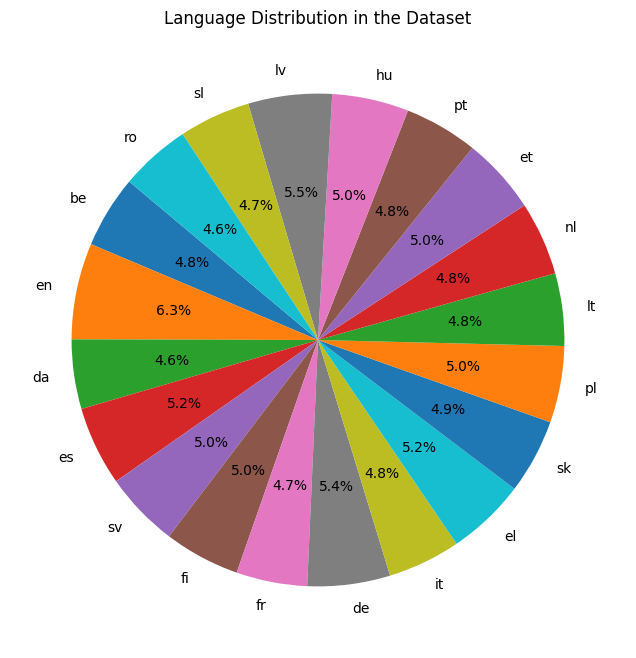

In [ ]:
sample_counts = Counter(labels)
plt.figure(figsize=(8, 8))
plt.pie(sample_counts.values(), labels=sample_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution in the Dataset')
plt.show()

### Sentence Lengths
This part of code creates and displays a histogram to show the distribution of sentence lengths (in terms of word count) across the dataset, helping to visualize how sentence lengths vary.

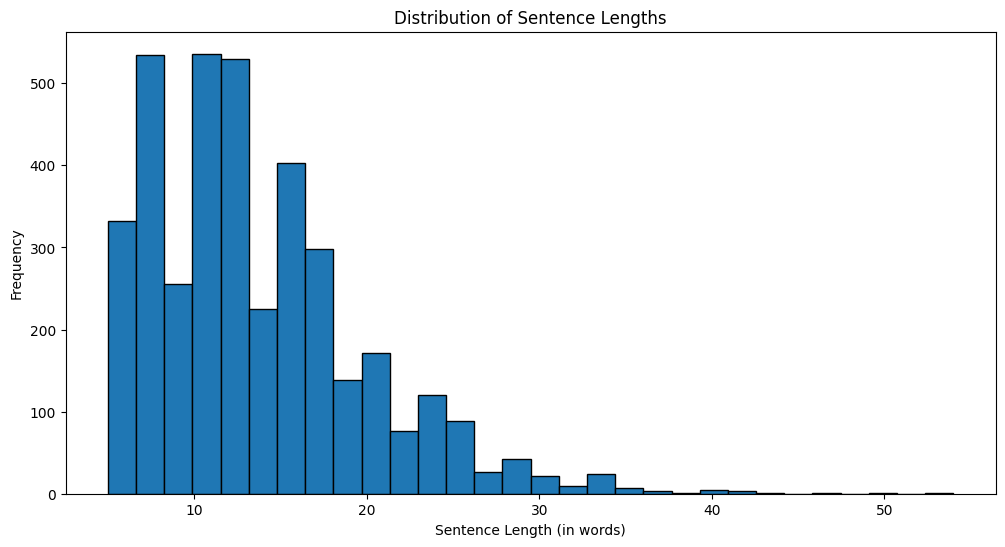

In [ ]:
sentence_lengths = [len(sentence.split()) for sentences in data.values() for sentence in sentences]
plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=30, edgecolor='black')
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

### Unique Trigrams per Language
This part of code visualization to compare the diversity of trigrams (word combinations) present in the text data for each language.

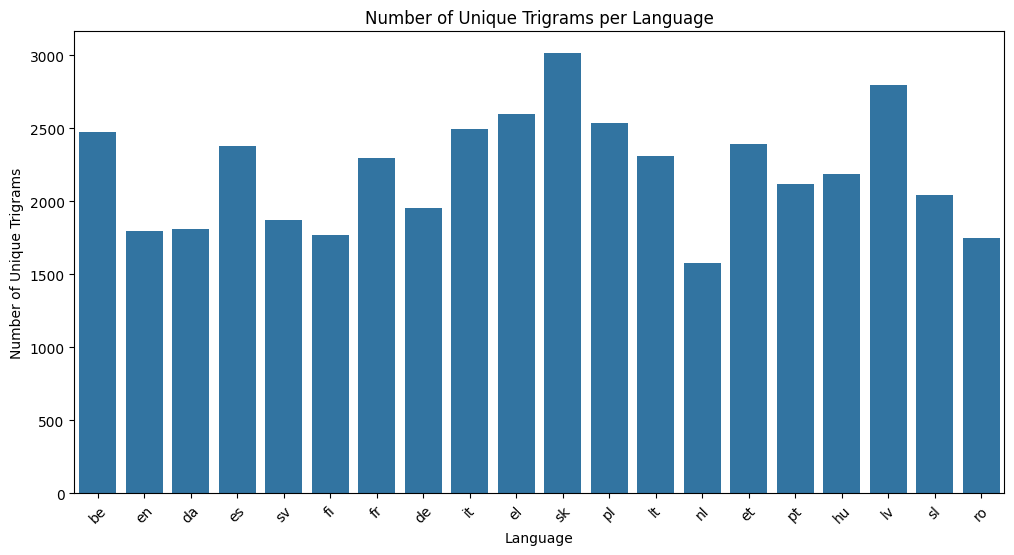

In [ ]:
unique_trigrams_counts = {lang: len(trigrams) for lang, trigrams in trigram_counts.items()}
plt.figure(figsize=(12, 6))
sns.barplot(x=list(unique_trigrams_counts.keys()), y=list(unique_trigrams_counts.values()))
plt.xlabel('Language')
plt.ylabel('Number of Unique Trigrams')
plt.title('Number of Unique Trigrams per Language')
plt.xticks(rotation=45)
plt.show()

### Word Cloud of Common Trigrams
This part of code visualization to identify the most common trigrams across the entire dataset, providing insights into frequently occurring word combinations in the text.

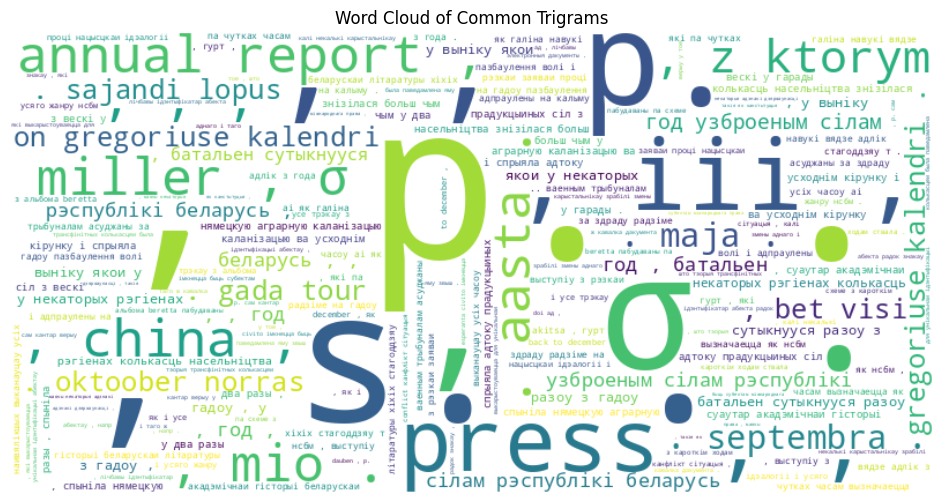

In [ ]:
all_trigrams = [trigram for trigrams in trigram_counts.values() for trigram in trigrams]
trigram_freq = Counter(all_trigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Trigrams')
plt.show()

### Trigram Frequency Distribution
This part of code visualize the most frequently occurring three-word combinations in the dataset, providing insights into commonly used phrases or sequences of words.

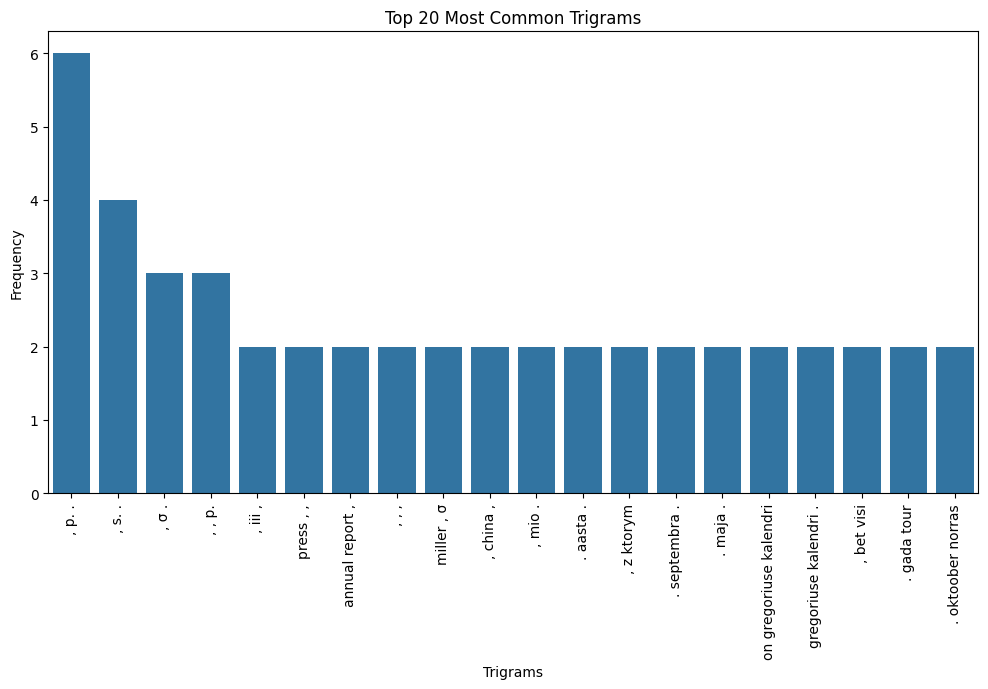

In [ ]:
trigram_freq = Counter(trigram for trigrams in trigram_counts.values() for trigram in trigrams)
common_trigrams = trigram_freq.most_common(20)
trigrams, counts = zip(*common_trigrams)
plt.figure(figsize=(12, 6))
sns.barplot(x=trigrams, y=counts)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Trigrams')
plt.xticks(rotation=90)
plt.show()

# Splitting Data
This part of code is converting a dataset of sentences into a format suitable for machine learning. It collects all sentences and their associated language labels into lists and then splits these lists into training and testing sets. The training set will be used to train a model, while the testing set will be used to evaluate its performance. The split ensures that 70% of the data is used for training and 30% for testing, with the division being reproducible due to a fixed random seed.

In [ ]:
all_sentences = []
all_labels = []
for lang, sentences in data.items():
    all_sentences.extend(sentences)
    all_labels.extend([lang] * len(sentences))

X_train, X_test, y_train, y_test = train_test_split(all_sentences, all_labels, test_size=0.3, random_state=42)

print(f"Training data: {len(X_train)} samples")
print(f"Testing data: {len(X_test)} samples")

Training data: 2699 samples
Testing data: 1157 samples


# Vectorize the Text Data with n-grams
This code generates High-Dimensional (HD) vectors for trigrams (three-character sequences) from a training dataset.

1.  **Define Dimensions** Specifies vector lengths of 100, 1,000, and 10,000 for the HD vectors.

2.  **Initialize Storage** Sets up a dictionary to store HD vectors for each dimension.
3.   **Generate HD Vectors** Creates random vectors for each trigram, converts them to binary values (+1 or -1), and stores them in the dictionary.
4.   **Extract Trigrams** Uses CountVectorizer to extract trigrams from the training data.
5.   **Generate Vectors** Applies the HD vector generation function to these trigrams for all defined dimensions.






In [ ]:
DIMENSIONS = [100, 1000, 10000]
hd_vectors = {dim: {} for dim in DIMENSIONS}

def generate_hd_vectors(trigrams, dimensions):
    """
    Generate random HD vectors for each trigram with the specified dimensions.
    The vectors are encoded in {+1, -1} representation.
    """
    for dim in dimensions:
        hd_vectors[dim] = {}
        print(f"Generating HD vectors for dimension: {dim}")
        for trigram in trigrams:
            vector = np.random.randn(dim)
            hd_vectors[dim][trigram] = np.where(vector >= 0, 1, -1)
        print(f"Generated {len(hd_vectors[dim])} HD vectors for dimension {dim}")

vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char')
X_train_trigrams = vectorizer.fit_transform(X_train)
trigrams = vectorizer.get_feature_names_out()

generate_hd_vectors(trigrams, DIMENSIONS)

print(f"Generated HD vectors for {len(trigrams)} trigrams with dimensions {DIMENSIONS}.")

Generating HD vectors for dimension: 100
Generated 14795 HD vectors for dimension 100
Generating HD vectors for dimension: 1000
Generated 14795 HD vectors for dimension 1000
Generating HD vectors for dimension: 10000
Generated 14795 HD vectors for dimension 10000
Generated HD vectors for 14795 trigrams with dimensions [100, 1000, 10000].


This code encodes sentences into High-Dimensional (HD) vectors using predefined trigrams. It performs the following tasks:

1. **Encode_sentence** Converts a sentence into an HD vector by tokenizing it into trigrams, aggregating their corresponding HD vectors, and normalizing the result.


2. **Encode Training Data** Processes each sentence in the training set, creating HD vectors for different dimensions and storing them in a dictionary.

3. **Encoded Data Information** Displays the dimensions of the encoded data, checks for non-zero elements, and prints the encoded vector for the first sentence.

4. **Example Check**: Demonstrates encoding for the first sentence and prints the HD vectors for various dimensions.

In [ ]:
def encode_sentence(sentence, hd_vectors, dim):
    """
    Encode a sentence into HD vectors using {+1, -1} representation.
    """
    vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char')
    trigrams = vectorizer.fit([sentence]).get_feature_names_out()
    features = np.zeros(dim)

    for trigram in trigrams:
        if trigram in hd_vectors:
            features += hd_vectors[trigram]
        else:
            print(f"Trigram '{trigram}' not found in HD vectors for dimension {dim}")

    features = np.where(features >= 0, 1, -1)

    return features

X_train_encoded = {}
for dim in DIMENSIONS:
    X_train_encoded[dim] = np.array([encode_sentence(sentence, hd_vectors[dim], dim) for sentence in X_train])

print(f"Encoded training data shapes: { {dim: X_train_encoded[dim].shape for dim in DIMENSIONS} }")

for dim, encoded_data in X_train_encoded.items():
    print(f"Sum of encoded vectors for dimension {dim}: {np.sum(encoded_data)}")

for dim in DIMENSIONS:
    print(f"\nEncoded vector for the first sentence in dimension {dim}:")
    print(X_train_encoded[dim][0])

sentence = X_train[0]
for dim in DIMENSIONS:
    encoded_vector = encode_sentence(sentence, hd_vectors[dim], dim)
    print(f"\nChecking trigram matches for the first sentence in dimension {dim}:")
    print(f"Encoded vector: {encoded_vector}")

Encoded training data shapes: {100: (2699, 100), 1000: (2699, 1000), 10000: (2699, 10000)}
Sum of encoded vectors for dimension 100: 11794
Sum of encoded vectors for dimension 1000: 100478
Sum of encoded vectors for dimension 10000: 1278864

Encoded vector for the first sentence in dimension 100:
[-1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1 -1
 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1
 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1  1 -1 -1 -1  1
  1 -1  1 -1]

Encoded vector for the first sentence in dimension 1000:
[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1  1 -1  1
 -1  1 -1 -1  1 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1  1 -1 -1  1  1  1
  1  1  1 -1 -1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1 -1
  1 -1  1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1  1  1 -1  1 -1 -1  1  1  1
 -1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 

This part of code checks if trigrams (three-character sequences) from a given sentence are present in the High-Dimensional (HD) vectors for different dimensions and prints the results.

In [ ]:
def check_trigrams(sentence, hd_vectors, dim):
    """
    Check if trigrams in a sentence are present in HD vectors and print details.
    """
    vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char')
    trigrams = vectorizer.fit([sentence]).get_feature_names_out()

    print(f"Trigrams from the sentence: {trigrams}")
    for trigram in trigrams:
        if trigram in hd_vectors:
            print(f"Trigram '{trigram}' found in HD vectors.")
        else:
            print(f"Trigram '{trigram}' not found in HD vectors.")

sentence = X_train[0]
for dim in DIMENSIONS:
    print(f"\nChecking trigram matches for the first sentence in dimension {dim}:")
    check_trigrams(sentence, hd_vectors[dim], dim)


Checking trigram matches for the first sentence in dimension 100:
Trigrams from the sentence: [' ап' ' на' ' не' ' сі' ' ін' 'et ' 'net' 't н' 'а н' 'апе' 'ары' 'ах '
 'ацы' 'еко' 'ера' 'ины' 'кот' 'мах' 'на ' 'нек' 'ншы' 'ных' 'ота' 'пер'
 'рац' 'рых' 'стэ' 'сіс' 'тар' 'тэм' 'х .' 'х а' 'х с' 'х і' 'цыи' 'шых'
 'ыин' 'ых ' 'эма' 'інш' 'іст']
Trigram ' ап' found in HD vectors.
Trigram ' на' found in HD vectors.
Trigram ' не' found in HD vectors.
Trigram ' сі' found in HD vectors.
Trigram ' ін' found in HD vectors.
Trigram 'et ' found in HD vectors.
Trigram 'net' found in HD vectors.
Trigram 't н' found in HD vectors.
Trigram 'а н' found in HD vectors.
Trigram 'апе' found in HD vectors.
Trigram 'ары' found in HD vectors.
Trigram 'ах ' found in HD vectors.
Trigram 'ацы' found in HD vectors.
Trigram 'еко' found in HD vectors.
Trigram 'ера' found in HD vectors.
Trigram 'ины' found in HD vectors.
Trigram 'кот' found in HD vectors.
Trigram 'мах' found in HD vectors.
Trigram 'на ' found in H

# Model Training

This part of code encodes sentences into HD vectors, processes labels, trains RidgeClassifier models for each dimension, and stores the models for future use.

1. **Encode Sentences** Transform each sentence into High-Dimensional (HD) vectors by extracting trigrams (three-character sequences) and aggregating their corresponding HD vectors to create feature vectors with specified dimensions.
2. **Encode Training Data** Apply the encoding process to all training sentences for each dimension and store these encoded feature vectors in a dictionary.
3. **Label Encoding** Convert categorical labels into numerical values using LabelEncoder to prepare them for model training.
4. **Train Models** Train RidgeClassifier models using the encoded training data for each dimension.
5. **Store Models** Save each trained RidgeClassifier model in a dictionary for later use.

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define the encoding function (based on previous context)
def encode_sentence(sentence, hd_vectors, dim):
    """
    Encode a sentence into HD vectors.
    """
    # Tokenize the sentence into trigrams
    trigrams = [sentence[i:i+3] for i in range(len(sentence)-2)]

    # Initialize a feature vector for the dimension
    features = np.zeros(dim)

    # Aggregate HD vectors for each trigram
    for trigram in trigrams:
        if trigram in hd_vectors:
            features += hd_vectors[trigram]
        else:
            # You can choose to handle missing trigrams differently if needed
            pass

    return features

# Define dimensions to be used
DIMENSIONS = [100, 1000, 10000]

# Assume X_train and y_train are already defined
# Encode the training data
def encode_train_data(X_train, hd_vectors, dimensions):
    """
    Encode training data sentences using HD vectors for each dimension.
    """
    encoded_train_data = {}
    for dim in dimensions:
        encoded_train_data[dim] = np.array([encode_sentence(sentence, hd_vectors[dim], dim) for sentence in X_train])
    return encoded_train_data

# Encode train data for each dimension
X_train_encoded = encode_train_data(X_train, hd_vectors, DIMENSIONS)

# Label encoding for y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Train models for each dimension
ridge_models = {}
for dim in DIMENSIONS:
    ridge_model = RidgeClassifier()
    ridge_model.fit(X_train_encoded[dim], y_train_encoded)
    ridge_models[dim] = ridge_model

print("Training complete.")

Training complete.


# Model Evaluation


# Model Testing on Unknow Sample
The pipeline preprocesses and encodes text samples into high-dimensional vectors, uses Ridge regression for predictions, evaluates performance with accuracy and F1 scores, and processes new sample predictions.


1. **Encode Query Sample** This function detects the language of an input text sample, preprocesses it accordingly, and then encodes the preprocesses text into high-dimensional vectors.
2.  **Label Encoding process**  This step converts training and testing labels into numeric format using LabelEncoder, storing them in y_train_encoded and y_test_encoded.
3. **Test Data Encoding** Encodes test dataset sentences into HD vectors for each dimension and stores the results in X_test_encoded.

4. **Prediction and Evaluation** Uses trained Ridge regression models to predict test outcomes, stores predictions in y_pred, evaluates model performance with accuracy and F1 scores, and displays confusion matrices.
5. **New Sample Prediction** Encodes a new text sample using encode_query_sample, predicts its label with trained models, and prints the predicted labels for each dimension.






In [ ]:
from sklearn.preprocessing import LabelEncoder

# Fit LabelEncoder with all labels encountered in training data
all_labels = list(LANGUAGE_MAP.keys())  # Replace this with actual labels if different
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

def predict_language(sample, models, hd_vectors, dimensions, label_encoder):
    """
    Predict the language of a sample using the trained models.
    """
    # Preprocess and encode the sample
    encoded_sample = {dim: encode_sentence(sample, hd_vectors[dim], dim) for dim in dimensions}

    # Collect predictions from each model
    predictions = {}
    for dim in dimensions:
        model = models[dim]
        features = encoded_sample[dim].reshape(1, -1)
        prediction = model.predict(features)
        predictions[dim] = prediction[0]

    # Combine predictions from different dimensions (e.g., by majority vote)
    prediction_counts = Counter(predictions.values())
    final_prediction_code = prediction_counts.most_common(1)[0][0]

    # Handle cases where final prediction might not be in known labels
    try:
        final_label = label_encoder.inverse_transform([final_prediction_code])[0]
    except ValueError:
        final_label = "Unknown"

    # Print individual model predictions
    print(f"Predictions for the sample in each dimension:")
    for dim, prediction in predictions.items():
        try:
            predicted_label = label_encoder.inverse_transform([prediction])[0]
        except ValueError:
            predicted_label = "Unknown"
        print(f"Dimension {dim}: Predicted language code: {predicted_label}")

    print(f"\nFinal predicted language: {final_label}")

    return final_label

def evaluate_model(sample, ground_truth, models, hd_vectors, dimensions, label_encoder):
    """
    Evaluate the model's performance on a single sample.
    """
    # Predict the language
    predicted_language = predict_language(sample, models, hd_vectors, dimensions, label_encoder)

    # Handle the case where the ground truth might not be in known labels
    try:
        ground_truth_encoded = label_encoder.transform([ground_truth])[0]
    except ValueError:
        print(f"Ground truth label '{ground_truth}' is not in the label encoder's known labels.")
        return

    # Convert predicted language to its encoded form
    try:
        predicted_encoded = label_encoder.transform([predicted_language])[0]
    except ValueError:
        print(f"Predicted label '{predicted_language}' is not in the label encoder's known labels.")
        return

    # Compute metrics
    y_true = [ground_truth_encoded]
    y_pred = [predicted_encoded]

    confusion = confusion_matrix(y_true, y_pred, labels=label_encoder.transform(label_encoder.classes_))
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\nConfusion Matrix:\n{confusion}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Example unknown text sample and its ground truth
unknown_sample = "Адзначае, што з'яўляецца паслядоўным апанентам рэжыму Лукашэнкі."
ground_truth = 'be'  # Replace with the actual ground truth language code

# Ensure ground_truth is a valid label in label_encoder
if ground_truth in label_encoder.classes_:
    # Evaluate the model
    evaluate_model(unknown_sample, ground_truth, ridge_models, hd_vectors, DIMENSIONS, label_encoder)
else:
    print(f"Ground truth '{ground_truth}' is not recognized by the label encoder.")

Predictions for the sample in each dimension:
Dimension 100: Predicted language code: en
Dimension 1000: Predicted language code: da
Dimension 10000: Predicted language code: be

Final predicted language: en

Confusion Matrix:
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 

Evalutaion on 30% Dataset

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np

def encode_test_data(X_test, hd_vectors, dimensions):
    """
    Encode test data sentences using HD vectors for each dimension.
    """
    encoded_test_data = {}
    for dim in dimensions:
        encoded_test_data[dim] = np.array([encode_sentence(sentence, hd_vectors[dim], dim) for sentence in X_test])
    return encoded_test_data

# Encode test data for each dimension
X_test_encoded = encode_test_data(X_test, hd_vectors, DIMENSIONS)

# Evaluate each model
results = {}
for dim in DIMENSIONS:
    # Make predictions
    y_test_pred_encoded = ridge_models[dim].predict(X_test_encoded[dim])
    y_test_pred = np.round(y_test_pred_encoded).astype(int)  # Round to nearest integer

    # Evaluate model
    y_test_encoded = label_encoder.transform(y_test)
    conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
    accuracy = accuracy_score(y_test_encoded, y_test_pred)
    f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

    results[dim] = {
        "Confusion Matrix": conf_matrix,
        "Accuracy": accuracy,
        "F1 Score": f1
    }

# Display results
for dim, result in results.items():
    print(f"Results for dimension {dim}:")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}\n")

Results for dimension 100:
Confusion Matrix:
[[48  1  0  4  0  0  1  0  1  0  0  1  2  0  1  0  0  0  0  0]
 [ 3 20  7  1  0  1  0  1  0  2  1  2  0  3  1  2  2  2  4  3]
 [ 0  0 39  2  0  0  1  1  3  1  0  2  2  5  0  1  1  1  1  1]
 [ 3  0  0 50  0  0  0  2  0  0  0  0  1  0  1  0  0  0  1  1]
 [12  2  2  4 10  5  1  1  2  4  5  2  3  3  3  2  4  4  2  0]
 [ 3  0  1  1  0 43  0  1  1  2  0  0  1  0  0  6  1  0  0  1]
 [ 1  0  1  1  0  0 40  4  2  0  2  0  3  0  1  1  1  4  1  0]
 [ 0  0  1  1  1  0  1 52  0  2  1  1  2  0  0  2  0  0  0  0]
 [ 3  2  1  3  0  1  1  0 32  0  1  2  1  0  0  3  2  1  0  0]
 [ 0  0  2  5  0  0  0  1  1 39  0  2  1  0  2  2  1  1  1  1]
 [ 0  0  0  1  0  5  0  0  3  0 36  0  0  0  2  3  0  2  0  1]
 [ 0  0  0  3  0  5  2  2  3  0  0 33  5  0  0  3  0  1  0  4]
 [ 2  0  0  0  0  0  0  2  1  1  0  1 47  0  0  2  0  0  1  4]
 [ 4  1 17  3  1  0  1  1  3  1  1  2  2 19  3  1  0  4  1  2]
 [ 2  1  0  0  0  0  1  1  0  1  0  1  1  0 37  2  2  4  2  0]
 [ 0  0  1

**DECISION TREE**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define the encoding function (based on previous context)
def encode_sentence(sentence, hd_vectors, dim):
    """
    Encode a sentence into HD vectors.
    """
    # Tokenize the sentence into trigrams
    trigrams = [sentence[i:i+3] for i in range(len(sentence)-2)]

    # Initialize a feature vector for the dimension
    features = np.zeros(dim)

    # Aggregate HD vectors for each trigram
    for trigram in trigrams:
        if trigram in hd_vectors:
            features += hd_vectors[trigram]
        else:
            # You can choose to handle missing trigrams differently if needed
            pass

    return features

# Define dimensions to be used
DIMENSIONS = [100, 1000, 10000]

# Assume X_train and y_train are already defined
# Encode the training data
def encode_train_data(X_train, hd_vectors, dimensions):
    """
    Encode training data sentences using HD vectors for each dimension.
    """
    encoded_train_data = {}
    for dim in dimensions:
        encoded_train_data[dim] = np.array([encode_sentence(sentence, hd_vectors[dim], dim) for sentence in X_train])
    return encoded_train_data

# Encode train data for each dimension
X_train_encoded = encode_train_data(X_train, hd_vectors, DIMENSIONS)

# Label encoding for y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Train Decision Tree models for each dimension
decision_tree_models = {}
for dim in DIMENSIONS:
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model.fit(X_train_encoded[dim], y_train_encoded)
    decision_tree_models[dim] = decision_tree_model

print("Training complete.")

Training complete.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np

def encode_test_data(X_test, hd_vectors, dimensions):
    """
    Encode test data sentences using HD vectors for each dimension.
    """
    encoded_test_data = {}
    for dim in dimensions:
        encoded_test_data[dim] = np.array([encode_sentence(sentence, hd_vectors[dim], dim) for sentence in X_test])
    return encoded_test_data

# Encode test data for each dimension
X_test_encoded = encode_test_data(X_test, hd_vectors, DIMENSIONS)

# Evaluate each Decision Tree model
results = {}
for dim in DIMENSIONS:
    # Make predictions using the decision tree models
    y_test_pred = decision_tree_models[dim].predict(X_test_encoded[dim])

    # Evaluate model
    y_test_encoded = label_encoder.transform(y_test)
    conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
    accuracy = accuracy_score(y_test_encoded, y_test_pred)
    f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

    results[dim] = {
        "Confusion Matrix": conf_matrix,
        "Accuracy": accuracy,
        "F1 Score": f1
    }

# Display results
for dim, result in results.items():
    print(f"Results for dimension {dim}:")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}\n")

Results for dimension 100:
Confusion Matrix:
[[ 7  0  2  5  3  3  2  1  2  4  0  2  4  5  2  5  3  2  5  2]
 [ 1  3  3  2  3  2  7  1  2  2  1  3  3  3  3  3  2  2  2  7]
 [ 4  5  3  2  2  2  6  3  4  1  2  2  2  3  3  4  3  3  2  5]
 [ 6  4  3 15  3  3  0  0  2  1  1  0  2  2  5  4  2  1  2  3]
 [ 3  5  3  1  6  7  3  2  0  2  6  1  2  6  4  5  3  5  5  2]
 [ 2  1  2  0  3 11  1  2  2  5  2  1  4  2  6  3  4  6  3  1]
 [ 1  4  4  2  2  1  9  6  3  3  2  4  6  1  3  3  1  2  4  1]
 [ 3  1  3  3  4  2  4 11  4  2  1  7  3  0  4  2  2  2  2  4]
 [ 3  2  3  1  2  3  3  1  6  3  1  1  3  2  1  3  2  3  3  7]
 [ 2  1  1  1  2  5  3  2  5  4  3  4  2  3  2  4  4  1  6  4]
 [ 2  3  1  2  0  6  2  2  4  2  5  3  5  3  0  1  4  1  6  1]
 [ 1  2  2  1  3  4  5  3  3  2  1  9  1  3  1  4  6  3  3  4]
 [ 2  0  3  1  1  3  4  2  3  8  2  3 10  3  2  2  2  6  2  2]
 [ 3  2  6  1  3  3  0  3  1  2  4  3  1 12  3  2  5  5  5  3]
 [ 3  3  3  3  2  3  3  0  3  3  0  4  3  2  4  6  3  2  4  1]
 [ 2  2  0